Malo o projektu: Određivanje rase pasa na osnovu unete slike 

### **Faza1**: Analiza podataka

Analiza podataka će omogućiti razumevanje skupa podataka koji će se koristiti za treniranje modela veštačke inteligencije. Ova faza biće realizovana u nekoliko koraka.

Skup podataka je preuzet sa [Dog Breeds Image Dataset on Kaggle](https://www.kaggle.com/datasets/darshanthakare/dog-breeds-image-dataset) i sačuvan je u folderu projekta na putanji data/DogBreedsImageDataset

Sve korišćene biblioteke navedene su u prvoj Code ćeliji 

In [74]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
import numpy as np
from matplotlib import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import accuracy_score
import shutil
from collections import Counter
import time
import cv2

Prebrojavanje koliko klasa (rasa) se nalazi u skupu podataka.


In [39]:
data_root = Path("data/DogBreedsImageDataset")
classes = [p for p in data_root.iterdir() if p.is_dir()]
print("Broj rasa:", len(classes))

Broj rasa: 124


Ukupan broj slika u skupu podataka.

In [40]:
image_count = len(list(data_root.glob('*/*.jpg')))
print("Ukupno slika:", image_count)

Ukupno slika: 17390


Provera da li je neki od foldera prazan.

In [41]:
empty_classes = []

for cls in classes:
    cls_path = cls
    count = len([f for f in cls_path.iterdir() if f.suffix.lower() == '.jpg'])
    if count == 0:
        empty_classes.append(cls_path.name)

if empty_classes:
    print("Prazni folderi (nema slika):")
    for cls in empty_classes:
        print(cls)
else:
    print("Nema praznih foldera. Sve klase imaju slike.")

Nema praznih foldera. Sve klase imaju slike.


Izračunati su broj klasa (rasa) i ukupan broj slika. Sada se računa broj slika po klasama. 

In [42]:
print("Broj slika po klasama:")

image_per_class=[]
for cls in classes:
    cls_path = cls  
    count = len([f for f in cls_path.iterdir() if f.suffix.lower() == '.jpg'])
    image_per_class.append(count)
    print(f"{cls_path.name}: {count} slika")

Broj slika po klasama:
affenpinscher: 134 slika
afghan_hound: 125 slika
african: 169 slika
airedale: 189 slika
american_terrier: 153 slika
appenzeller: 135 slika
australian_cattledog: 18 slika
australian_terrier: 181 slika
basenji: 170 slika
basset_hound: 149 slika
beagle: 172 slika
bedlington_terrier: 148 slika
bernese_mountain: 190 slika
bichon_frise: 11 slika
blenheim_spaniel: 157 slika
blood_hound: 135 slika
bluetick: 147 slika
border_collie: 155 slika
border_terrier: 147 slika
borzoi: 107 slika
boston_bulldog: 173 slika
bouvier: 119 slika
boxer: 149 slika
brabancon: 141 slika
briard: 136 slika
brittany_spaniel: 136 slika
bull_mastiff: 137 slika
cairn_terrier: 177 slika
cardigan_corgi: 132 slika
caucasian_ovcharka: 30 slika
chesapeake_retriever: 142 slika
chihuahua: 129 slika
chow: 183 slika
clumber: 116 slika
cockapoo: 16 slika
cocker_spaniel: 174 slika
coonhound: 130 slika
curly_retriever: 129 slika
dachshund: 31 slika
dandie_terrier: 148 slika
dhole: 150 slika
dingo: 148 slika
d

Ove podatke je moguće vizuelizovati. Koristi se *import matplotlib.pyplot as plt* za kreiranje horizontalnog bar grafa (<span style="color:pink">barh</span>). Rase su poređane abecedno, kako su i navedene u skupu podataka. 

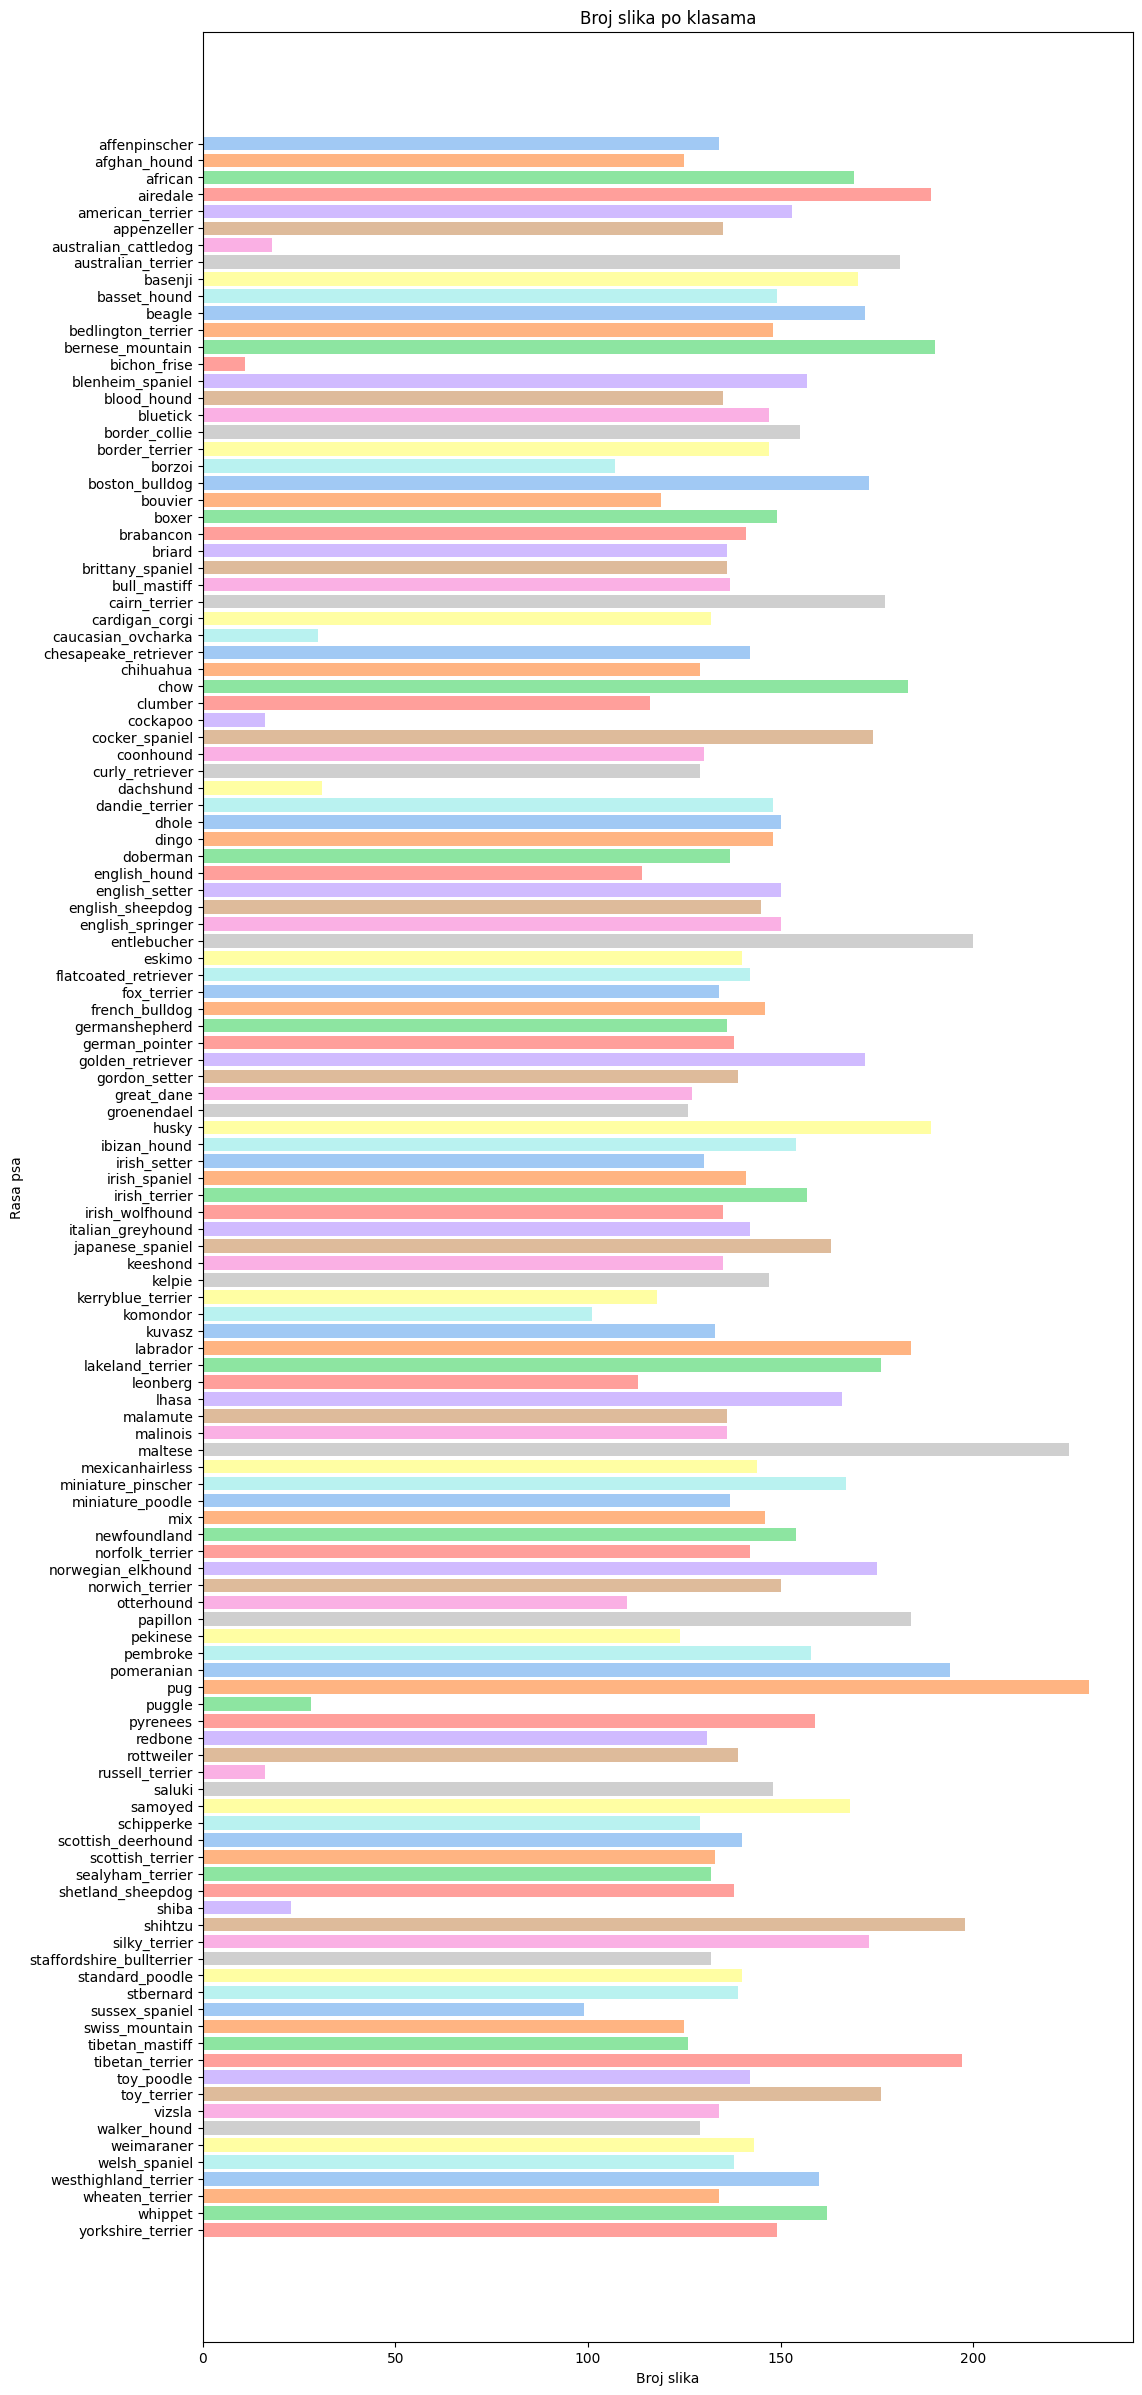

In [43]:
class_names = [cls.name for cls in classes] 

plt.figure(figsize=(12,30))
colors = sns.color_palette("pastel", len(classes))
plt.barh(class_names, image_per_class, color=colors)
plt.xlabel('Broj slika')
plt.ylabel('Rasa psa')
plt.title('Broj slika po klasama')
plt.gca().invert_yaxis()  
plt.show()

Sledeći graf prikazuje broj slika po rasama od najvećeg broja slika po klasi do najmanjeg. 

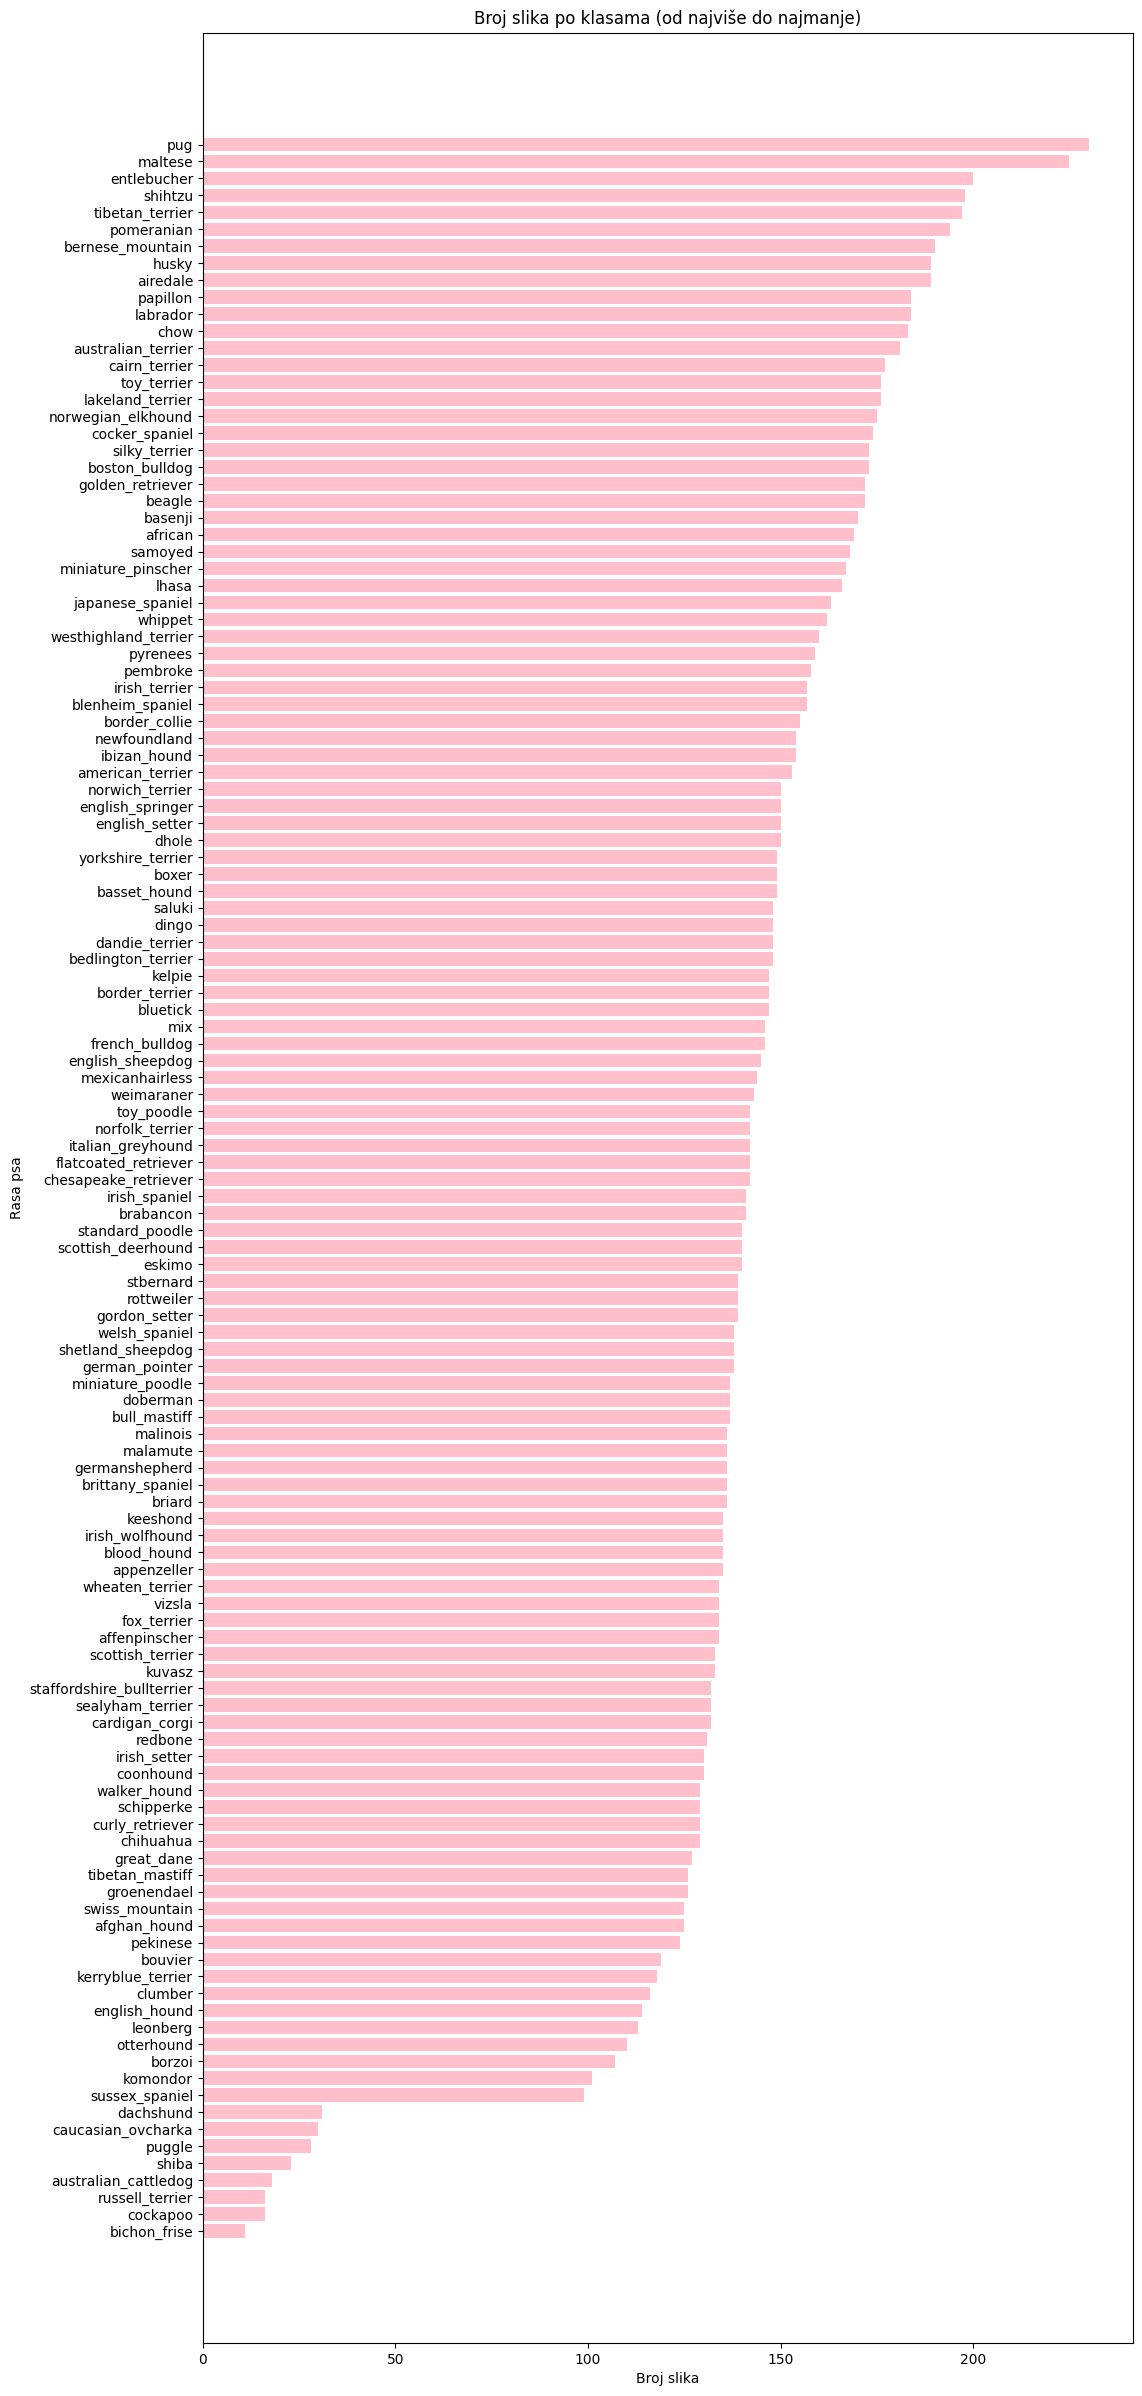

In [44]:

sorted_pairs = sorted(zip(image_per_class, class_names), reverse=True)
sorted_counts, sorted_classes = zip(*sorted_pairs)


plt.figure(figsize=(12,30))
plt.barh(sorted_classes, sorted_counts, color='pink')
plt.xlabel('Broj slika')
plt.ylabel('Rasa psa')
plt.title('Broj slika po klasama (od najviše do najmanje)')
plt.gca().invert_yaxis()  
plt.show()

Precizno određujemo koji je najmanji a koji najveći broj slika po klasama. Na osnovu grafika iznad može se proceniti da veći broj klasa ima najmanji broj slika, pa se ispisuju sve klase sa najvećim i sa najmanjim brojem.  

In [45]:
min_count = min(image_per_class)
max_count = max(image_per_class)

min_classes = [cls.name for cls, count in zip(classes, image_per_class) if count == min_count]
max_classes = [cls.name for cls, count in zip(classes, image_per_class) if count == max_count]

print(f"Folderi sa najmanje slika ({min_count}): {min_classes}")
print(f"Folderi sa najviše slika ({max_count}): {max_classes}")

Folderi sa najmanje slika (11): ['bichon_frise']
Folderi sa najviše slika (230): ['pug']


In [65]:
def filter_classes_by_count(data_dir, min_samples=10):
    """
    Uklanja klase sa manje od min_samples primeraka
    """
    
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            num_samples = len([f for f in os.listdir(class_dir) 
                             if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = num_samples
    
    
    removed_count = 0
    for class_name, count in class_counts.items():
        if count < min_samples:
            class_dir = os.path.join(data_dir, class_name)
            shutil.rmtree(class_dir)
            print(f"Obrisana klasa '{class_name}' sa {count} samples")
            removed_count += 1
    
    print(f"Ukupno obrisanih klasa: {removed_count}")
    return class_counts
class_counts = filter_classes_by_count(data_root, min_samples=10)


print("\nPreostale klase:")
for class_name, count in sorted(class_counts.items()):
    if count >= 10:
        print(f"{class_name}: {count} samples")

Ukupno obrisanih klasa: 0

Preostale klase:
affenpinscher: 134 samples
afghan_hound: 125 samples
african: 169 samples
airedale: 189 samples
american_terrier: 153 samples
appenzeller: 135 samples
australian_cattledog: 18 samples
australian_terrier: 181 samples
basenji: 170 samples
basset_hound: 149 samples
beagle: 172 samples
bedlington_terrier: 148 samples
bernese_mountain: 190 samples
bichon_frise: 11 samples
blenheim_spaniel: 157 samples
blood_hound: 135 samples
bluetick: 147 samples
border_collie: 155 samples
border_terrier: 147 samples
borzoi: 107 samples
boston_bulldog: 173 samples
bouvier: 119 samples
boxer: 149 samples
brabancon: 141 samples
briard: 136 samples
brittany_spaniel: 136 samples
bull_mastiff: 137 samples
cairn_terrier: 177 samples
cardigan_corgi: 132 samples
caucasian_ovcharka: 30 samples
chesapeake_retriever: 142 samples
chihuahua: 129 samples
chow: 183 samples
clumber: 116 samples
cockapoo: 16 samples
cocker_spaniel: 174 samples
coonhound: 130 samples
curly_retriev

Prikaz podataka (slika), i to po 3 primerka za prvih 5 klasa.

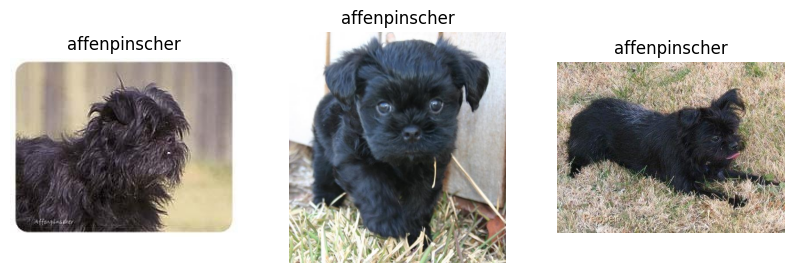

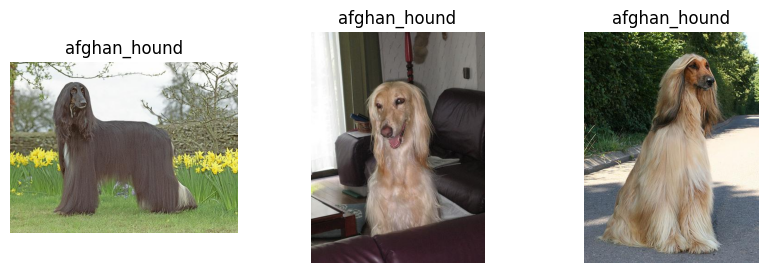

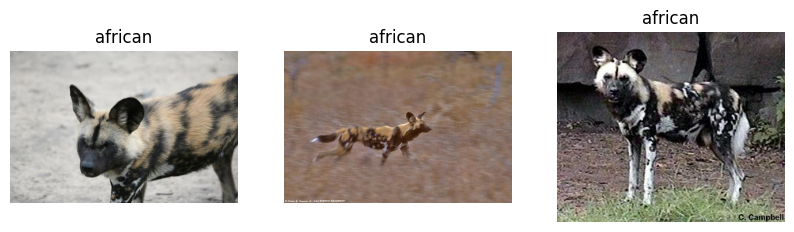

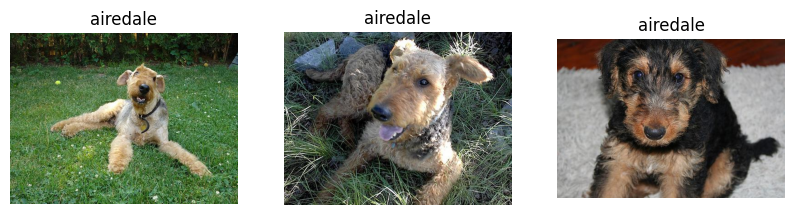

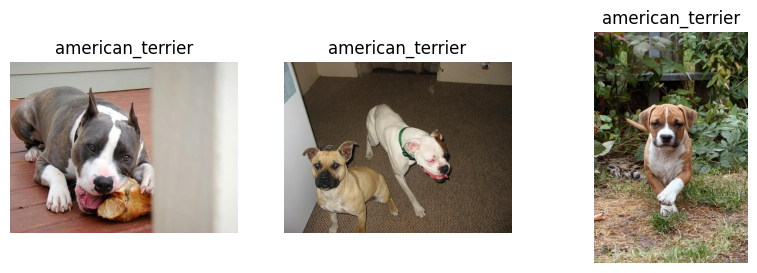

In [46]:
for cls in classes[:5]:
    imgs = list(cls.iterdir())
    random_imgs = random.sample(imgs, min(3, len(imgs)))
    plt.figure(figsize=(10,3))
    for i, img_path in enumerate(random_imgs):
        img = Image.open(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls.name)
    plt.show()

Možemo primetiti da slike nisu istih dimenzija! Taj deo će biti obrađen u narednoj fazi, odnosno u okviru predprocesiranja podataka, a u nastavku če biti analizirane dimenzije slika.

In [47]:
widths, heights = [], []

for cls in classes:
    for img_path in cls.iterdir():
        if img_path.suffix.lower() == '.jpg':
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)



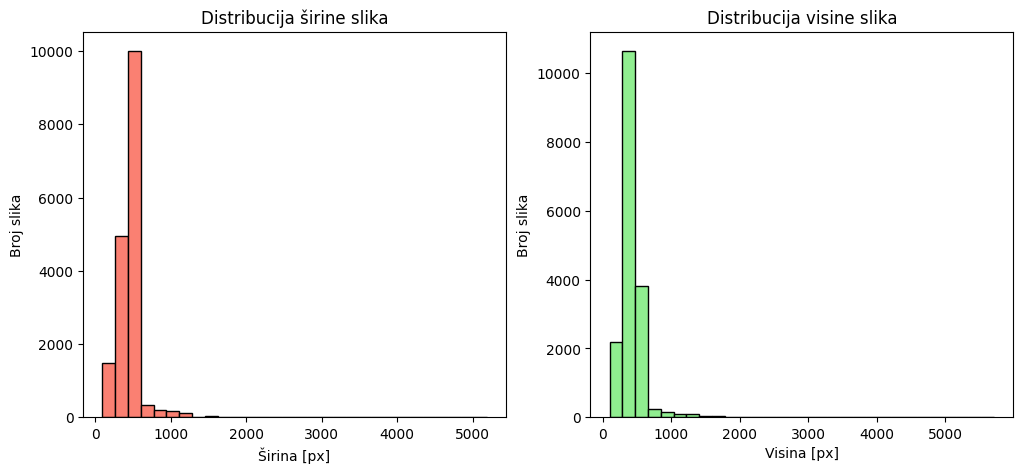

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='salmon', edgecolor='black')
plt.xlabel('Širina [px]')
plt.ylabel('Broj slika')
plt.title('Distribucija širine slika')

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Visina [px]')
plt.ylabel('Broj slika')
plt.title('Distribucija visine slika')
plt.show()

**Problem**: Veliki broj klasa (>120) a relativno mali broj slika (≈17000). Broj slika je previše mali da bi razvnomerno bio raspoređen na ovaj broj klasa, samim tim smanjuje se šansa da model dobro klasifikuje. 

**Rešenje**:Za treniranje modela izdvojeno je 5 klasa: *pug, husky, maltese, golden_retriever i labrador*. Kriterijum za odabir ovih klasa bila je raznolikost izmedju samih rasa kao i veći broj slika po klasama. Kreira se novi dataset, koji kosirti samo ove klase za dalji rad.

In [100]:
selected_class_names = ["pug", "husky", "maltese", "golden_retriever", "labrador", "cocker_spaniel"]
selected_classes = [p for p in classes if p.name in selected_class_names]

print("Broj izabranih rasa:", len(selected_classes))
print("Izabrane klase:", [c.name for c in selected_classes])

Broj izabranih rasa: 6
Izabrane klase: ['cocker_spaniel', 'golden_retriever', 'husky', 'labrador', 'maltese', 'pug']


In [101]:
images = []
for cls in selected_classes:
    for img_path in cls.glob("*.*"):  # učitava sve slike
        images.append((img_path, cls.name))

print("Ukupno slika za trening:", len(images))

Ukupno slika za trening: 1175


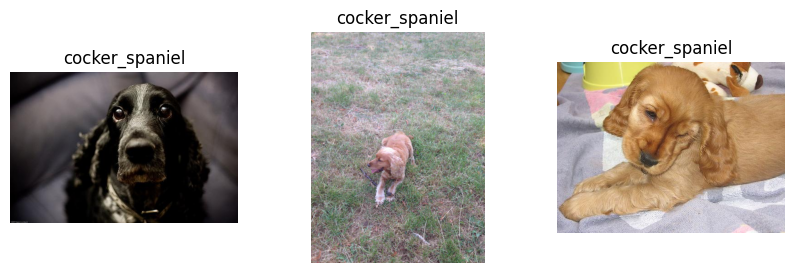

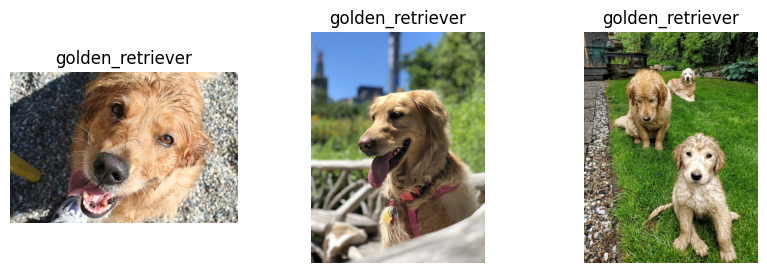

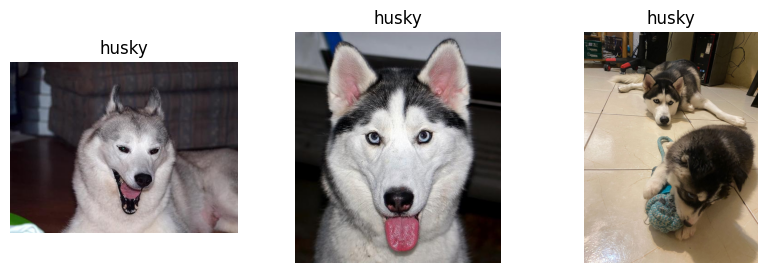

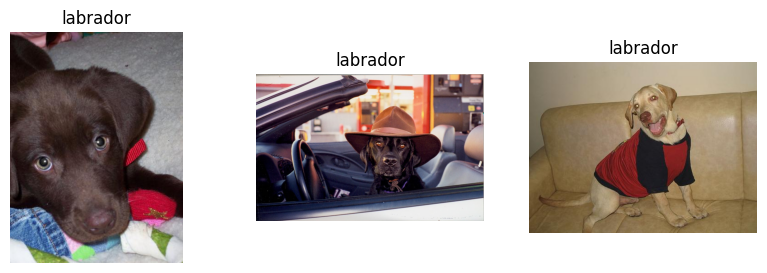

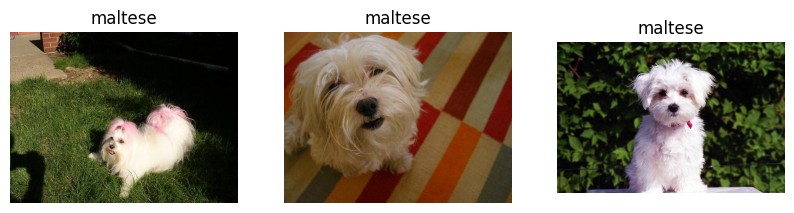

In [102]:
for cls in selected_classes[:5]:
    imgs = list(cls.iterdir())
    random_imgs = random.sample(imgs, min(3, len(imgs)))
    plt.figure(figsize=(10,3))
    for i, img_path in enumerate(random_imgs):
        img = Image.open(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls.name)
    plt.show()

In [103]:
class_counts = {}
for cls in selected_classes:
    image_count = len(list(cls.glob("*.*")))  
    class_counts[cls.name] = image_count

print("Broj slika po klasama:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Broj slika po klasama:
cocker_spaniel: 174
golden_retriever: 173
husky: 189
labrador: 184
maltese: 225
pug: 230


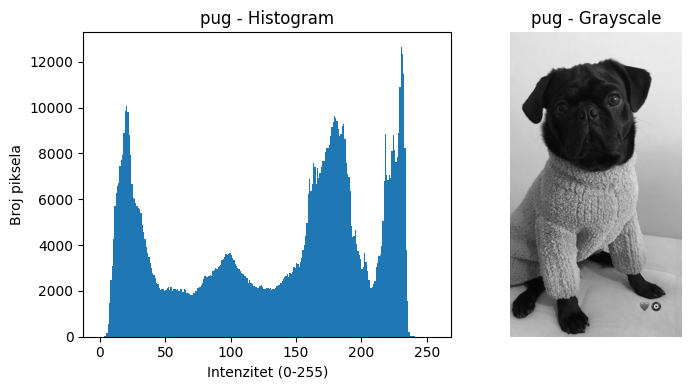

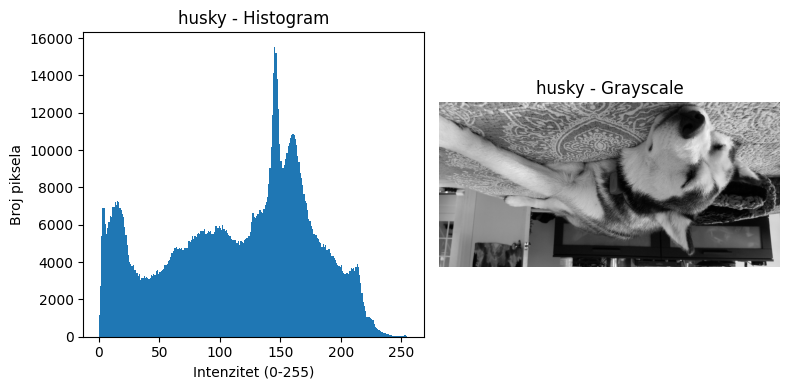

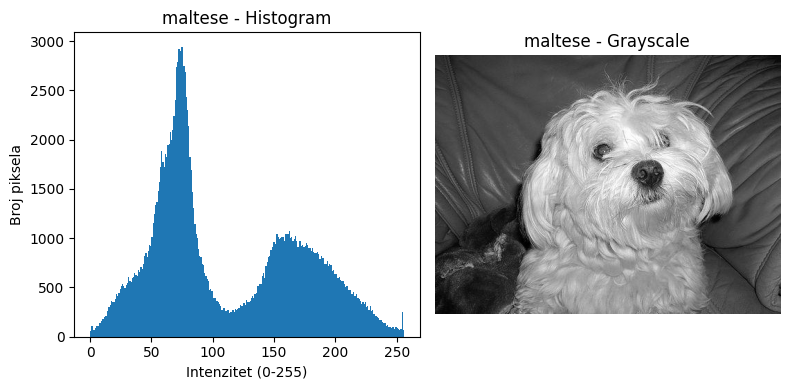

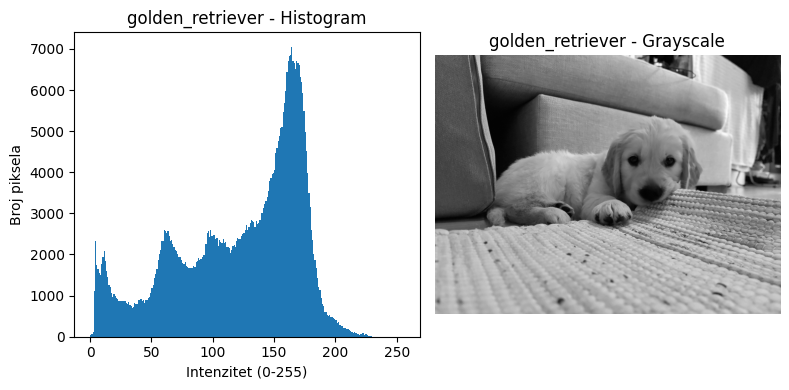

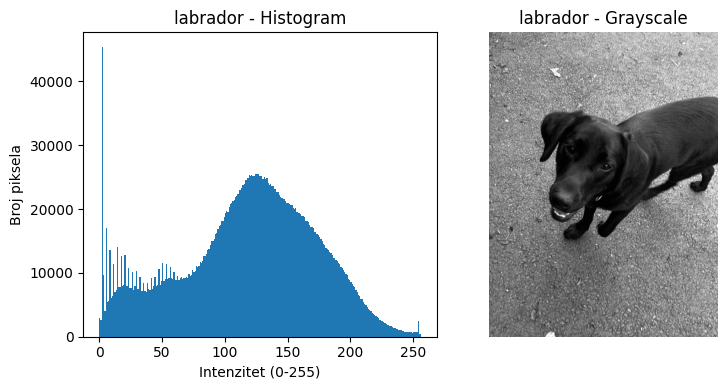

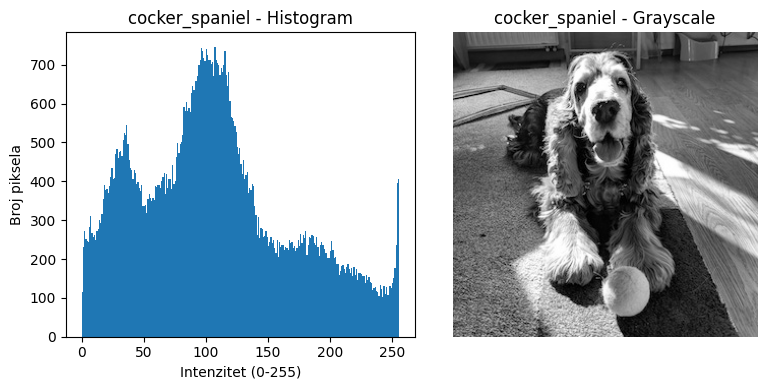

In [104]:
for class_name in selected_class_names:
    class_folder = data_root / class_name
    example_img_path = next(class_folder.glob("*.*"))  # uzima prvu sliku iz klase

    img = cv2.imread(str(example_img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(8, 4))

    # levi subplot: histogram
    plt.subplot(1, 2, 1)
    plt.hist(img_gray.ravel(), bins=256, range=[0, 256])
    plt.title(f"{class_name} - Histogram")
    plt.xlabel("Intenzitet (0-255)")
    plt.ylabel("Broj piksela")

    # desni subplot: grayscale slika
    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap="gray")
    plt.title(f"{class_name} - Grayscale")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [105]:
import hashlib

all_images = []
for cls in selected_classes:
    all_images.extend(cls.glob("*")) 

def file_hash(path):
    hasher = hashlib.md5()
    with open(path, "rb") as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

hashes = {}
duplicates = []

for img in all_images:
    h = file_hash(img)
    if h in hashes:
        duplicates.append((img, hashes[h]))  
    else:
        hashes[h] = img

if duplicates:
    print("Duplikati slika:")
    for dup in duplicates:
        print(dup[0], "<==>", dup[1])
else:
    print("Nema duplikata slika")


Duplikati slika:
data\DogBreedsImageDataset\golden_retriever\golden_retriever_1.jpg <==> data\DogBreedsImageDataset\golden_retriever\golden_retriever_1 - Copy.jpg


### **Faza2**:Pipeline za treniranje, validaciju i testiranje modela

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Train: 822, Val: 176, Test: 177
Predikcija train skupa...
Predikcija val skupa...
Predikcija test skupa...
Evaluacija na val skupu (samo odabrane klase):
                  precision    recall  f1-score   support

             pug       1.00      0.76      0.87        34
           husky       1.00      0.89      0.94        28
         maltese       1.00      1.00      1.00        34
golden_retriever       0.89      0.96      0.93        26
        labrador       1.00      0.79      0.88        28
  cocker_spaniel       1.00      0.96      0.98        26

       micro avg       0.98      0.89      0.93       176
       macro avg       0.98      0.89      0.93       176
    weighted avg       0.98      0.89      0.93       176



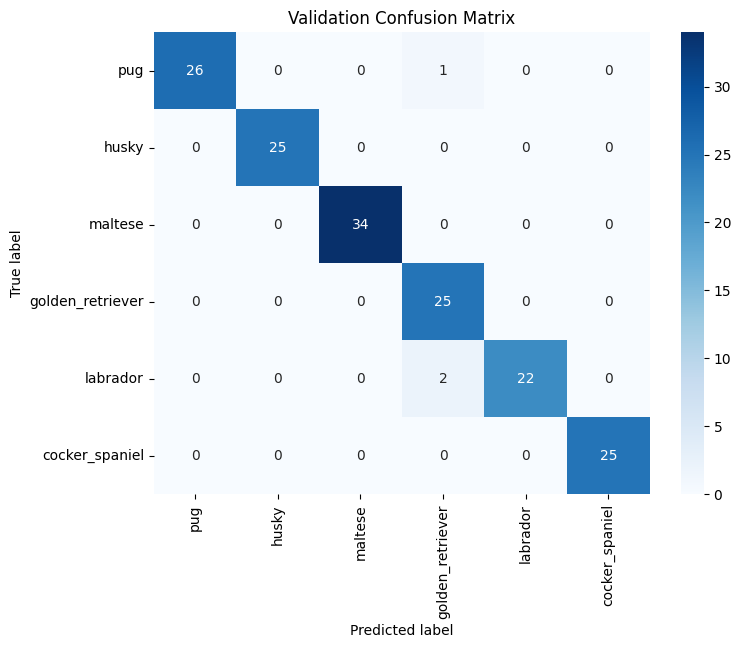

Accuracy: 0.8920
Evaluacija na test skupu (samo odabrane klase):
                  precision    recall  f1-score   support

             pug       1.00      0.91      0.96        35
           husky       1.00      0.90      0.95        29
         maltese       1.00      1.00      1.00        34
golden_retriever       0.96      0.92      0.94        26
        labrador       1.00      0.93      0.96        27
  cocker_spaniel       1.00      0.81      0.89        26

       micro avg       0.99      0.92      0.95       177
       macro avg       0.99      0.91      0.95       177
    weighted avg       0.99      0.92      0.95       177



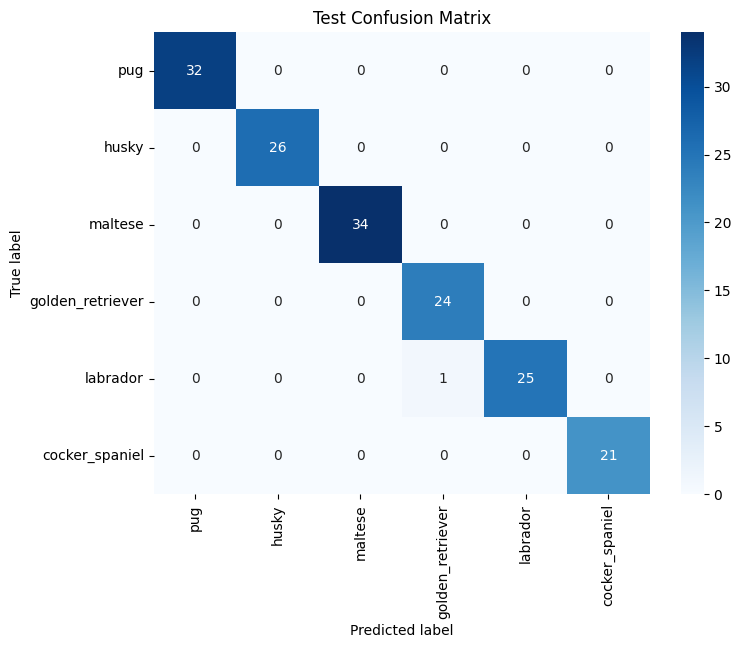

Accuracy: 0.9153
Pipeline završena i rezultati sačuvani!


In [ ]:
# ------------------------------- Uvoz biblioteka -------------------------------
import os
from pathlib import Path
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

# ------------------------------- Parametri -------------------------------
data_dir = Path("data/DogBreedsImageDataset")
selected_class_names = ["pug", "husky", "maltese", "golden_retriever", "labrador", "cocker_spaniel"]
model_name = "wesleyacheng/dog-breeds-multiclass-image-classification-with-vit"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------- Učitavanje modela lokalno -------------------------------
processor = AutoImageProcessor.from_pretrained(model_name)
model1 = AutoModelForImageClassification.from_pretrained(model_name)
model1.to(device)
model1.eval()

# ------------------------------- Priprema podataka -------------------------------
image_paths = []
labels = []

for cls_name in selected_class_names:
    cls_path = data_dir / cls_name
    for img_file in cls_path.iterdir():
        if img_file.suffix.lower() in [".jpg", ".png", ".jpeg"]:
            image_paths.append(img_file)
            labels.append(cls_name)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Podela na train/val/test 70/15/15
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ------------------------------- Funkcija za predikciju lokalno -------------------------------
def predict_local(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model1(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predicted_label = model1.config.id2label[predicted_class_idx]
    return predicted_label

# ------------------------------- Predikcija celog skupa -------------------------------
def get_predictions_local(df):
    preds = []
    for path in df["image_path"]:
        preds.append(predict_local(path))
    return preds

print("Predikcija train skupa...")
train_preds = get_predictions_local(train_df)

print("Predikcija val skupa...")
val_preds = get_predictions_local(val_df)

print("Predikcija test skupa...")
test_preds = get_predictions_local(test_df)

# ------------------------------- Funkcija za filtriranje na odabrane klase -------------------------------
class_mapping = {
    "pug": "pug",
    "husky": "siberian_husky",
    "maltese": "maltese_dog",
    "golden_retriever": "golden_retriever",
    "labrador": "labrador_retriever",
    "cocker_spaniel":"cocker_spaniel"
}

# Funkcija za filtriranje i mapiranje predikcija
def filter_and_map_classes(y_true, y_pred, class_mapping):
    filtered_true = []
    filtered_pred = []
    # invertovana mapa: model_label -> tvoj_label
    model_to_local = {v: k for k, v in class_mapping.items()}
    
    for t, p in zip(y_true, y_pred):
        if t in class_mapping:
            filtered_true.append(t)
            # mapiranje predikcije modela na tvoju klasu
            mapped_pred = model_to_local.get(p, "unknown")
            filtered_pred.append(mapped_pred)
    return filtered_true, filtered_pred

# ------------------------------- Evaluacija -------------------------------
def evaluate(y_true, y_pred, title="Confusion Matrix"):
    labels_for_eval = [cls for cls in selected_class_names if cls in y_true]
    print(classification_report(y_true, y_pred, labels=labels_for_eval, target_names=labels_for_eval))
    cm = confusion_matrix(y_true, y_pred, labels=labels_for_eval)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_for_eval, yticklabels=labels_for_eval, cmap="Blues")
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    return acc

# Filtriranje predikcija na odabrane klase
val_labels_filtered, val_preds_filtered = filter_and_map_classes(val_df["label"].tolist(), val_preds, class_mapping)
test_labels_filtered, test_preds_filtered = filter_and_map_classes(test_df["label"].tolist(), test_preds, class_mapping)

print("Evaluacija na val skupu (samo odabrane klase):")
val_acc = evaluate(val_labels_filtered, val_preds_filtered, "Validation Confusion Matrix")

print("Evaluacija na test skupu (samo odabrane klase):")
test_acc = evaluate(test_labels_filtered, test_preds_filtered, "Test Confusion Matrix")

# ------------------------------- Čuvanje rezultata -------------------------------
test_df["predicted"] = test_preds
test_df.to_csv("predictions_test.csv", index=False)

metrics = {"val_accuracy": val_acc, "test_accuracy": test_acc}
pd.DataFrame([metrics]).to_csv("metrics.csv", index=False)

print("Pipeline završena i rezultati sačuvani!")


Koristim uređaj: cpu
✅ Dataset filtriran na 5 klasa i sačuvan u: data\DogBreedsImageDataset_filtered
Klase u datasetu: ['golden_retriever', 'husky', 'labrador', 'maltese', 'pug']
Train: 700, Val: 150, Test: 151
Epoch [1/5] | Train Loss: 0.6545 | Train Acc: 0.7814 | Val Loss: 0.1725 | Val Acc: 0.9600
Epoch [2/5] | Train Loss: 0.0703 | Train Acc: 0.9914 | Val Loss: 0.1592 | Val Acc: 0.9467
Epoch [3/5] | Train Loss: 0.0231 | Train Acc: 1.0000 | Val Loss: 0.1462 | Val Acc: 0.9600
Epoch [4/5] | Train Loss: 0.0128 | Train Acc: 1.0000 | Val Loss: 0.1488 | Val Acc: 0.9533
Epoch [5/5] | Train Loss: 0.0085 | Train Acc: 1.0000 | Val Loss: 0.1465 | Val Acc: 0.9533


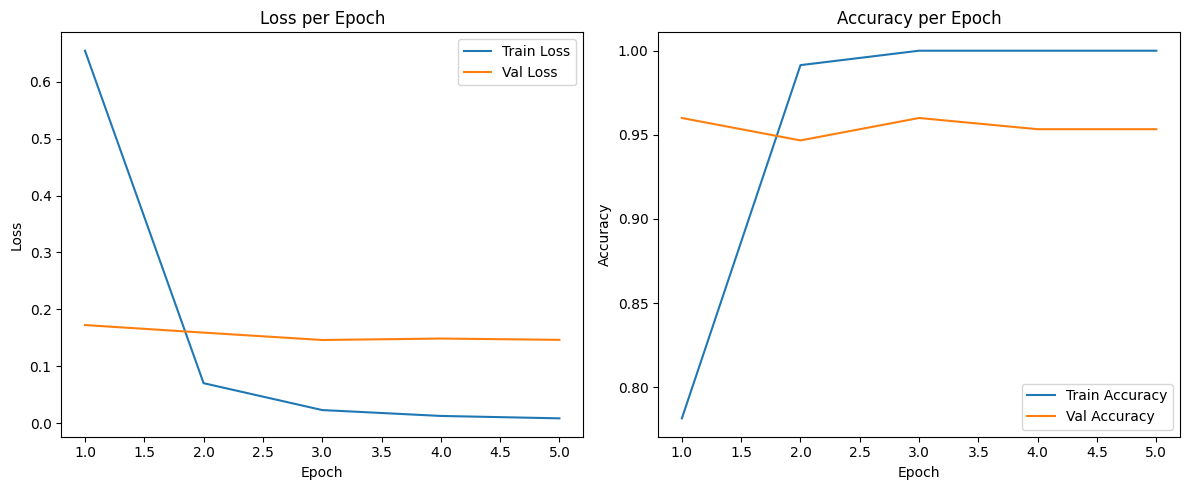

Test Accuracy: 0.9669
✅ Model sačuvan kao dog_breed_classifier_5classes.pth


In [110]:
# ------------------------------- Uvoz biblioteka -------------------------------
import os
from pathlib import Path
import shutil
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# ------------------------------- Parametri -------------------------------
original_data_dir = Path("data/DogBreedsImageDataset")
filtered_data_dir = Path("data/DogBreedsImageDataset_filtered")
selected_classes = ["pug", "husky", "maltese", "golden_retriever", "labrador"]

batch_size = 32
num_epochs = 5
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")

# ------------------------------- Filtriranje klasa -------------------------------
filtered_data_dir.mkdir(exist_ok=True)
for cls in selected_classes:
    src = original_data_dir / cls
    dst = filtered_data_dir / cls
    if not dst.exists():
        shutil.copytree(src, dst)

print(f"✅ Dataset filtriran na {len(selected_classes)} klasa i sačuvan u: {filtered_data_dir}")

# ------------------------------- Transformacije -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------------- Dataset i podela -------------------------------
full_dataset = datasets.ImageFolder(filtered_data_dir, transform=transform)
class_names = full_dataset.classes
print(f"Klase u datasetu: {class_names}")

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ------------------------------- Model -------------------------------
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ------------------------------- Trening -------------------------------
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ---- Trening ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # ---- Validacija ----
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

# ------------------------------- Plot Loss & Accuracy -------------------------------
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------- Evaluacija na test skupu -------------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

# ------------------------------- Čuvanje modela -------------------------------
torch.save(model.state_dict(), "dog_breed_classifier_5classes.pth")
print("✅ Model sačuvan kao dog_breed_classifier_5classes.pth")


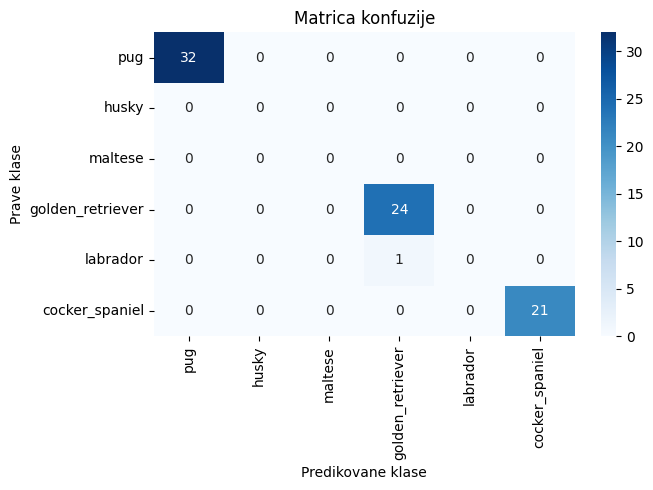

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names, title="Matrica konfuzije"):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predikovane klase")
    plt.ylabel("Prave klase")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 🔥 Poziv posle predikcija:
plot_confusion_matrix(test_df["label"].tolist(), test_preds, selected_class_names)


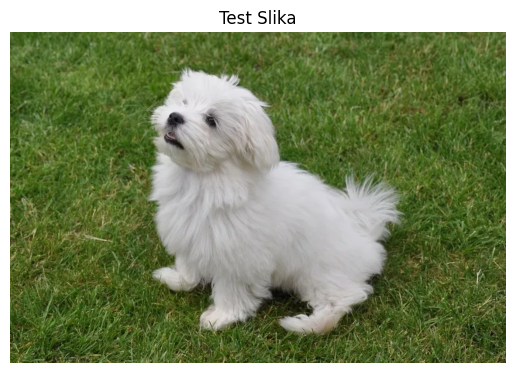

Predviđena klasa: golden_retriever


In [113]:
# ------------------------------- Uvoz biblioteka -------------------------------
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# ------------------------------- Parametri -------------------------------
class_names = ["pug", "husky", "maltese", "golden_retriever", "labrador"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "dog_breed_classifier_5classes.pth"

# ------------------------------- Učitavanje modela -------------------------------
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ------------------------------- Transformacije -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------------------- Učitavanje slike sa linka -------------------------------
#url = "https://content.lyka.com.au/f/1016262/1104x676/3233341a1e/pug.webp/m/640x427/smart"
url = "https://www.zooplus.hr/magazin/wp-content/uploads/2022/01/Stene-maltezera.webp"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Prikaz slike
plt.imshow(img)
plt.axis("off")
plt.title("Test Slika")
plt.show()

# ------------------------------- Predikcija -------------------------------
input_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_label = class_names[predicted_idx.item()]

print(f"Predviđena klasa: {predicted_label}")


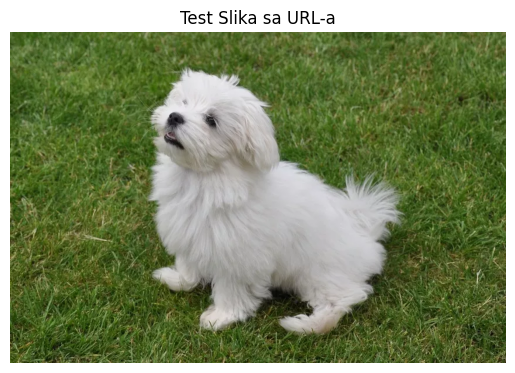

Predviđena klasa: golden_retriever


In [119]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Transformacije (isto kao kod treninga)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Funkcija za predikciju sa ResNet
def predict_resnet_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    
    # Prikaz slike
    plt.imshow(img)
    plt.axis("off")
    plt.title("Test Slika sa URL-a")
    plt.show()
    
    # Transformacija slike
    img_tensor = transform(img).unsqueeze(0).to(device)  # dodaj batch dimenziju
    
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_label = class_names[predicted_idx.item()]
    
    print(f"Predviđena klasa: {predicted_label}")
    return predicted_label

# Primer
#url = "https://content.lyka.com.au/f/1016262/1104x676/3233341a1e/pug.webp/m/640x427/smart"
url = "https://www.zooplus.hr/magazin/wp-content/uploads/2022/01/Stene-maltezera.webp"
predicted_class = predict_resnet_from_url(url)
